In [68]:
import numpy as np
from random import random
from random import randrange
from matplotlib import pyplot as plt
import math
from scipy.integrate import quad
from scipy.optimize import fsolve
import copy

In [27]:
def el_2(xi):
    """Renvoie exp(i*xi*lambda_2)"""
    return np.array([[np.cos(xi), np.sin(xi), 0],
                     [-np.sin(xi), np.cos(xi), 0],
                     [0,0,1]])


def el_3(xi):
    return np.array([[np.exp(xi*1j), 0, 0],
                     [0,np.exp(-xi*1j),0],
                     [0, 0,1]])


def el_5(xi):
    return np.array([[np.cos(xi), 0, np.sin(xi)],
                     [0,1,0],
                     [-np.sin(xi), 0,np.cos(xi)]])

def el_8(xi):
    return np.array([[np.exp((xi/np.sqrt(3))*1j), 0, 0],
                     [0,np.exp((xi/np.sqrt(3))*1j),0],
                     [0, 0,np.exp(-2*(xi/np.sqrt(3))*1j)]])
def el(xi,index):
    if (index == 2):
        return el_2(xi)
    if (index == 3):
        return el_3(xi)
    if (index == 5):
        return el_5(xi)
    if (index == 8):
        return el_8(xi)

In [3]:
def mat_rand_su3():
    """Renvoie une matrice aléatoire de su(3) en utilisant la paramétrisation de l'article geometry of su(3)"""
    alpha, gamma, a, c = random()*np.pi,random()*np.pi,random()*np.pi,random()*np.pi
    beta, b, theta = random()*np.pi/2,random()*np.pi/2,random()*np.pi/2
    phi = random()*2*np.pi
    return el_3(alpha) @ el_2(beta) @ el_3(gamma) @ el_5(theta) @ el_3(a) @ el_2(b) @ el_3(c) @ el_8(phi)

In [4]:
def est_SU3(U, tol=1e-10):
    """
    Vérifie si une matrice 3x3 U appartient au groupe SU(3).
    
    Arguments :
    - U : ndarray, matrice 3x3 à vérifier
    - tol : float, tolérance pour les erreurs numériques lors de la comparaison

    Retourne :
    - bool : True si la matrice est dans SU(3), False sinon
    """
    # Vérifier l'unitarité : U * U_dagger = I
    U_dagger = np.conjugate(U.T)
    identite = np.eye(3, dtype=complex)
    
    if not np.allclose(U @ U_dagger, identite, atol=tol):
        return False  # La matrice n'est pas unitaire
    
    # Vérifier que le déterminant est égal à 1 : det(U) = 1
    if not np.isclose(np.linalg.det(U), 1, atol=tol):
        return False  # Le déterminant n'est pas égal à 1
    
    return True  # La matrice est dans SU(3)


In [5]:
M = mat_rand_su3()
#M_d = np.conjugate(M.T)
#print(np.linalg.det(M))
#print(M @ M_d)
print(est_SU3(M))

True


In [6]:
def init_conf(L=3, T=3, cold=True):
    """Renvoie une configuration de jauge:
    L,T : dimensions de la lattice
    mu : nb d'indices de Dirac (=nb de liens de jauge par point de la lattice
    cold : booléen, si true : on génére une conf froide (id partout), sinon conf chaude
    Le résultat est une lattice de taille L,T avec conditions aux bords non périodiques. Mais on a pas besoin de modifier explicitement les bords, on a juste à appeler les lien avec modulo
    En chaque point (x,t) de la lattice, espace en ligne et temps en colonnes, il y a 2 matrices de SU3 repérées par l'indice mu, ce sont les 4 liens
    de jauge reliées au point (x,t)
    """
    mu = 2
    conf = np.zeros((L,T,mu,3,3), dtype=complex)
    for x in range(L):
        for t in range(T):
            for u in range(mu):
                if (cold):
                    conf[x,t,u] = np.eye(3)
                else:
                    conf[x,t,u] = mat_rand_su3()
    return conf


In [7]:
def conf_est_SU3(conf, tol=1e-10):
    """
    Vérifie si toutes les matrices 3x3 d'une configuration appartiennent au groupe SU(3).
    
    Arguments :
    - conf : ndarray, configuration LxTxmux3x3 à vérifier
    - tol : float, tolérance pour les erreurs numériques lors de la comparaison

    Retourne :
    - bool : True si la matrice est dans SU(3), False sinon
    """
    L,T,mu,*_ = conf.shape
    for i in range(L):
        for j in range(T):
            for u in range(mu):
                if not est_SU3(conf[i,j,u]):
                    return False
    return True

In [8]:
c = init_conf(3,3,cold=False)
conf_est_SU3(c)

True

In [9]:
def get_link(conf, x, t, mu):
    """
    Récupère le lien (matrice de jauge) à (x, t) dans la direction mu (0=x, 1=t)
    avec conditions aux bords périodiques.
    """
    L,T,*_=conf.shape
    x_pbc = x % L  # Appliquer périodicité en x
    t_pbc = t % T  # Appliquer périodicité en t
    return conf[x_pbc, t_pbc, mu]

In [10]:
def update_link(conf, x, t, mu, new_matrix):
    """
    Met à jour le lien (x, t, mu) en le multipliant a gauche avec une nouvelle matrice, en appliquant
    les conditions aux bords périodiques.
    """
    L,T,*_=conf.shape
    x_pbc = x % L
    t_pbc = t % T
    conf[x_pbc, t_pbc, mu] = new_matrix@conf[x_pbc, t_pbc, mu]

In [11]:
def calculate_plaquette(gauge_config, x, t):
    """
    Calcule la plaquette à un site donné (x, t).
    """
    L,T,*_=gauge_config.shape
    # Liens nécessaires
    Ux = get_link(gauge_config, x%L, t%T, 0)  # Lien dans x
    Ut = get_link(gauge_config, x%L, t%T, 1)  # Lien dans t
    Ux_t = get_link(gauge_config, x%L, (t + 1) % T, 0)  # Lien dans x au site (x, t+1)
    Ut_x = get_link(gauge_config, (x + 1) % L, t%T, 1)  # Lien dans t au site (x+1, t)
    
    # Plaquette
    plaquette = Ux @ Ut_x @ np.conj(Ux_t.T) @ np.conj(Ut.T)
    return plaquette

In [12]:
def calculate_action(conf, beta):
    L,T,*_=conf.shape
    action = 0
    for x in range(L):
        for t in range(T):
            plaquette_xt = calculate_plaquette(conf,x,t)
            i = np.eye(3,dtype=complex)
            action += np.trace(i-plaquette_xt).real
    action = action*(beta/3)
    return action
            

In [13]:
c = init_conf(3,3,cold=False)
print(calculate_action(c, 3))

24.619399093431692


In [14]:
def calculate_diff_action(conf, x,t,mu,m, beta):
    """
    Calcule la différence d'action entre la configuration de jauge conf et conf où on change le lien x, t, mu en m
    delta S = new - old (proba d'acceptation MCMC en exp(-delta S)
    """
    conf_new = conf
    update_link(conf_new,x,t,mu,m)
    action_old = calculate_action(conf, beta)
    action_new = calculate_action(conf_new,beta)
    diff = action_new-action_old
    return diff

In [15]:
def solve_trig_eq(a, b, c):
    # Vérification de la condition c / sqrt(a^2 + b^2) ∈ [-1, 1]
    R = math.sqrt(a**2 + b**2)
    if abs(c) > R:
        raise ValueError("No solution: |c| must be ≤ sqrt(a^2 + b^2).")
    
    # Calcul de theta
    theta = math.atan2(b, a)  # atan2 donne le bon quadrant pour cos(theta) et sin(theta)
    
    # Calcul des solutions principales
    cos_argument = c / R
    acos_value = math.acos(cos_argument)
    
    # Deux solutions principales
    x1 = theta + acos_value
    x2 = theta - acos_value
    
    # Réduction dans [0, 2*pi]
    x1 = x1 % (2 * math.pi)
    x2 = x2 % (2 * math.pi)
    
    return min(x1,x2), max(x1,x2)

# Exemple d'utilisation
a, b, c = 3, 4, 2  # Exemple avec a=3, b=4, c=2
solutions = solve_trig_eq(a, b, c)
print("Solutions dans [0, 2*pi] :", solutions)

Solutions dans [0, 2*pi] : (2.0865746987290206, 6.05120104445379)


In [16]:
def reduce(a,b,c):
    """
    Renvoie c modulo 2sqrt(a**2+b**2) tel que c/sqrt(a**2+b**2) est compris entre -1 et 1
    """
    R = 2*np.sqrt(a**2 + b**2)
    resc = c%R
    if (resc > R/2):
        resc -= R
    return resc

In [17]:
def coeffs(plaquette, index_lambda):
    """
    Renvoie les coeffs a,b,c de ReTr(X plaquette) = acos(xi) +bsin(xi) +c avec X = exp(i xi lambda_index_lambda)
    valable uniquement pour index_lambda = 2,3,5
    """
    a,b,c = 0,0,0
    if (index_lambda==2):
        a = (plaquette[0,0]+plaquette[1,1]).real
        b = (plaquette[1,0]-plaquette[0,1]).real
        c = plaquette[2,2].real
    if (index_lambda==3):
        a = (plaquette[0,0]+plaquette[1,1]).real
        b = (-plaquette[0,0]+plaquette[1,1]).imag
        c = plaquette[2,2].real
    if (index_lambda==5):
        a = (plaquette[0,0]+plaquette[2,2]).real
        b = (plaquette[2,0]-plaquette[0,2]).real
        c = plaquette[1,1].real
    return a,b,c

def coeffs_8(plaquette):
    a = (plaquette[0,0]+plaquette[1,1]).real
    b = (-plaquette[0,0]-plaquette[1,1]).imag
    c = plaquette[2,2].real
    d = plaquette[2,2].imag
    return a,b,c,d

In [18]:
def f_lambda_8_solve(xi, a, b, c, d, gamma):
    return a*np.cos(xi/np.sqrt(3))+b*np.sin(xi/np.sqrt(3))+c*np.cos(2*xi/np.sqrt(3))+d*np.sin(2*xi/np.sqrt(3)) - gamma

def derivee_f_lambda_8(xi,a,b,c,d):
    return -a/np.sqrt(3)*np.sin(xi/np.sqrt(3))+b/np.sqrt(3)*np.cos(xi/np.sqrt(3))-2*c/np.sqrt(3)*np.sin(2*xi/np.sqrt(3))+2*d/np.sqrt(3)*np.cos(2*xi/np.sqrt(3))

def derivee_f_lambda_8_plus(xi, a,b,c,d):
    return max(0, derivee_f_lambda_8(xi,a,b,c,d))

def reduce_8(a,b,c,d, gamma):
    #Réduit le réel gamma modulo l'énergie gagnée sur une période pour lambda_8
    R,*_ = quad(derivee_f_lambda_8_plus, 0, 2* np.sqrt(3) * np.pi, args=(1,1,1,1))
    resgamma = gamma%R
    if (resgamma > R/2):
        resgamma -= R
    return resgamma

def solve_rejet_8(a,b,c,d,gamma):
    """
    Résout l'équation f_lambda_8_solve(xi,a,b,c,d,gamma) = 0 modulo une période -> retourne le xi rejet pour lambda_8
    """
    x_ini = 0
    solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
    #print(f_lambda_8_solve(solution[0]%(2*np.sqrt(3)*np.pi),a,b,c,d,gamma))
    return solution[0]%(2*np.sqrt(3)*np.pi)
    

In [19]:
def ECMC_step(conf, x, t, mu, index_lambda, beta):
    """
    Effectue une étape de ECMC : renvoie la matrice X = exp(i xi lambda_{indice_lambda}) et l'angle xi de l'évènement de rejet pour
    le lien (x,t,mu) de la configuration conf, ainsi que next_link le lien dans la plaquette responsable du rejet qui devra être changé ensuite
    index_lambda peut valoir 2,3,5,8 uniquement
    """

    if (index_lambda!=2) and (index_lambda!=3) and (index_lambda!=5) and (index_lambda!=8):
        raise ValueError("Wrong index_lambda value, must be in {2,3,5,8}")
    #On calcule les deux plaquettes contenant le lien :
    L,T,*_ = conf.shape
    plaquette_1 = calculate_plaquette(conf,x,t)
    plaquette_2 = np.eye(3, dtype = complex)
    if (mu==0):
        plaquette_2 = calculate_plaquette(conf, x, t-1)
    if (mu==1):
        plaquette_2 = calculate_plaquette(conf, x-1, t) 

    #Le xi rejet qui sera rendu à la fin
    xi = 0
    
    #xi rejet dans les plaquettes 1 et 2
    xi_min_1 = 0
    xi_min_2 = 0
    
    p = random()
    gamma1 = (-3/beta)*math.log(p) + np.trace(plaquette_1).real
    gamma2 = (-3/beta)*math.log(p) + np.trace(plaquette_2).real

    #On calcule les coefficients a,b et c de l'équation acos(xi)+bsin(xi)=c à résoudre, dans le cas ou on est pas sur lambda_8
    if (index_lambda != 8):
        a1, a2 = 0, 0
        b1, b2 = 0, 0
        a1, b1, cc1 = coeffs(plaquette_1, index_lambda)
        a2, b2, cc2 = coeffs(plaquette_2, index_lambda)
        c1 = gamma1 - cc1
        c2 = gamma2 - cc2
    
        #On enlève les contributions périodiques
        c1 = reduce(a1,b1,c1)
        c2 = reduce(a2,b2,c2)

        #On trouve xi rejet
        xi_min_1,*_ = solve_trig_eq(a1, b1, c1)
        xi_min_2,*_ = solve_trig_eq(a2, b2, c2)

        

    #Si on est sur lambda_8 :
    if (index_lambda == 8):
        a1,b1,c1,d1 = coeffs_8(plaquette_1)
        a2,b2,c2,d2 = coeffs_8(plaquette_2)
        xi_min_1 = solve_rejet_8(a1,b1,c1,d1,gamma1)
        xi_min_2 = solve_rejet_8(a2,b2,c2,d2,gamma2)
    
    
    #On choisit le xi le plus petit
    xi = min(xi_min_1, xi_min_2)

    
    #On choisit le prochain lien a modifier dans la plaquette responsable du refus, en prenant le prochain lien dans le sens trigo
    #(les plaquettes sont orientées dans le sens trigo)
    if (xi_min_1<=xi_min_2):
        #print("Refus dans la 1ère plaquette")
        if (mu==0):
            next_link = ((x+1)%L,t,1)
        if (mu==1):
            next_link = (x,t,0)
        
    else:
        #print("Refus dans la 2ème plaquette")
        if (mu==0):
            next_link = (x,(t-1)%T,1)
        if (mu==1):
            next_link = ((x-1)%L,(t-1)%T,0)
            
    if (index_lambda==2):
        X = el_2(xi)
    if (index_lambda==3):
        X = el_3(xi)
    if (index_lambda==5):
        X = el_5(xi)
    if (index_lambda==8):
        X = el_8(xi)

    return X, xi, next_link

In [20]:
c = init_conf(3,3,cold=False)
beta = 2.5
print(calculate_action(c, beta))
index_lambda=8
X, xi, next_link = ECMC_step(c,2,1,1,index_lambda,beta)
x,t,mu = next_link
update_link(c, x,t,mu, X)
print(calculate_action(c,beta))

23.83396991993516
23.877300581735913


In [37]:
def ECMC_step_l(conf, x, t, mu, beta, angle_l, lambda_l, pos_l):
    """
    Renvoie la configuration conf après des étapes ECMC en partant du point x,t,mu jusq'à ce que la distance totale parcourue en angle
    soit de angle_l
    lambda_l : longueur de déplacement au bout de laquelle on change la direction de déplacement
    pos_l : longueur de déplacement au bout de laquelle on change aléatoirement de lien de jauge
    """
    if (angle_l<=0):
        raise ValueError("l doit être strictement positif")
        
    L, T, *_ = conf.shape
    
    #Position du lien courant (celui qui se fait modifier)
    x_c = x%L
    t_c = t%T
    mu_c = mu
    
    #angle total
    angle = 0
    
    
    #liste des indices de lambda dans l'ordre et déplacement total depuis le dernier changement de direction
    index_lambda = [8, 3, 2, 3, 5, 3, 2, 3]
    i = 0
    angle_lambda = 0

    #déplacement total depuis le dernier changement de lien aléatoire
    angle_pos = 0

    #Pour afficher la progression
    printer = 0
    print("Variables initialisées, lancement de la boucle...")
    while (angle < angle_l):
        
        X, xi, next_link = ECMC_step(conf, x_c, t_c, mu_c, index_lambda[i], beta)
        
        if (angle + xi  > angle_l) or (angle_pos + xi > pos_l) or (angle_lambda + xi > lambda_l):
            
            diff_angle = angle_l - angle
            diff_pos = pos_l - angle_pos
            diff_lambda = lambda_l - angle_lambda
            min_diff = min(diff_angle, diff_pos, diff_lambda)
            
            if (min_diff == diff_angle):
                X = el(diff_angle, index_lambda[i])
                update_link(conf, x_c, t_c, mu_c, X)
                angle = angle_l
                print("Angle limite atteint")
                
            if (min_diff == diff_pos):
                X = el(diff_pos, index_lambda[i])
                update_link(conf, x_c, t_c, mu_c, X)
                x_c, t_c, mu_c = randrange(0, L), randrange(0,T), randrange(0,2)
                angle_pos = 0
                print("Changement de lien aléatoire")
                
            if (min_diff == diff_lambda):
                X = el(diff_lambda, index_lambda[i])
                update_link(conf, x_c, t_c, mu_c, X)
                x_c, t_c, mu_c = next_link
                i += 1
                i = i%len(index_lambda)
                angle_lambda = 0
                print("Changement de direction de déplacement")
        else :
            update_link(conf, x_c, t_c, mu_c, X)
            x_c, t_c, mu_c = next_link
            angle += xi
            angle_pos += xi
            angle_lambda += xi

        if (angle>printer*(angle_l/10)):
            print(str(printer * 10) + "% de l parcourus")
            printer += 1
    print("Fini !")
                

In [53]:
#c = init_conf(3,3,cold=True)
beta = 2.5
angle_l = 1200
lambda_l = 150
pos_l = 170
print(calculate_action(c, beta))
ECMC_step_l(c, 1, 1, 0, beta, l, lambda_l, pos_l)
print(calculate_action(c, beta))

24.620493138814357
Variables initialisées, lancement de la boucle...
0% de l parcourus


/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))


10% de l parcourus
Changement de direction de déplacement
Changement de lien aléatoire
20% de l parcourus
Changement de direction de déplacement
Changement de lien aléatoire
30% de l parcourus
Changement de direction de déplacement
40% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
50% de l parcourus
Changement de lien aléatoire
60% de l parcourus
Changement de direction de déplacement
70% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
80% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
90% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
Angle limite atteint
Fini !
23.661838472106943


In [79]:
def ECMC_samples(L=4, T=4, cold = True, beta=2.55, angle_l=1200, lambda_l=150, pos_l=300, n=5):
    """
    Renvoie une liste de n samples de configurations de jauge de taille L,T générées par ECMC, plus la configuration de départ au début
    cold : True si départ à froid, False si hot start
    beta : couplage de l'action LQCD pure jauge
    angle_l : distance parcourue (en angle) au bout de laquelle on prélève un sample
    pos_l : distance parcourue (en angle) au bout de laquelle reset aléatoire de lien à modifier
    lambda_l : distance parcourue (en angle) au bout de laquelle changement de l'angle de déplacement (déterministe, cf décomposition SU(3))
    """
    conf = init_conf(L, T, cold)
    x, t, mu = randrange(0,L), randrange(0,T), randrange(0,2)
    sample = [copy.deepcopy(conf)]
    for i in range(n):
        print("Génération du sample " +  str(i+1) + "...")
        ECMC_step_l(conf, x, t, mu, beta, angle_l, lambda_l, pos_l)
        conf_sample = copy.deepcopy(conf)
        sample += [conf_sample]
        print("Sample " + str(i+1) + " généré !")
    print("Tous les samples ont été générés avec succès !")
    return sample
    

In [ ]:
def walker_action(L = 4, T = 4, beta = 2.55, cold = True, angle_l = 1200, lambda_l = 150, pos_l = 500, n=3):
    """
    Renvoie la liste des actions d'une liste de n samples générés avec ECMC_samples
    """
    sample_walker = ECMC_samples(L, T, cold, beta, angle_l, lambda_l, pos_l,n)
    actions = [calculate_action(i, beta) for i in sample_walker]
    return actions

In [70]:
sample = ECMC_samples()

Génération du sample 1...
Variables initialisées, lancement de la boucle...
0% de l parcourus


/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))


10% de l parcourus
Changement de direction de déplacement
20% de l parcourus
Changement de direction de déplacement
Changement de lien aléatoire
30% de l parcourus
Changement de direction de déplacement
40% de l parcourus
Changement de direction de déplacement
Changement de lien aléatoire
50% de l parcourus
60% de l parcourus
Changement de direction de déplacement
70% de l parcourus
Changement de direction de déplacement
Changement de lien aléatoire
80% de l parcourus
Changement de direction de déplacement
90% de l parcourus
Changement de direction de déplacement
Changement de lien aléatoire
Angle limite atteint
Fini !
Sample 1 généré !
Génération du sample 2...
Variables initialisées, lancement de la boucle...
0% de l parcourus
10% de l parcourus
Changement de direction de déplacement
20% de l parcourus
Changement de direction de déplacement
Changement de lien aléatoire
30% de l parcourus
Changement de direction de déplacement
40% de l parcourus
Changement de direction de déplacement


In [73]:
actions = walker_action()
print(actions)

Génération du sample 1...
Variables initialisées, lancement de la boucle...
0% de l parcourus


/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))


Changement de direction de déplacement
10% de l parcourus
Changement de direction de déplacement
20% de l parcourus
Changement de direction de déplacement
Changement de lien aléatoire
Changement de direction de déplacement
30% de l parcourus
Changement de direction de déplacement
40% de l parcourus
Changement de direction de déplacement
Changement de lien aléatoire
50% de l parcourus
Changement de direction de déplacement
Changement de direction de déplacement
60% de l parcourus
Changement de direction de déplacement
70% de l parcourus
Changement de direction de déplacement
Changement de lien aléatoire
80% de l parcourus
Changement de direction de déplacement
Changement de direction de déplacement
90% de l parcourus
Changement de direction de déplacement
Changement de lien aléatoire
Angle limite atteint
Fini !
Sample 1 généré !
Génération du sample 2...
Variables initialisées, lancement de la boucle...
0% de l parcourus
Changement de direction de déplacement
10% de l parcourus
Changeme

In [92]:
import multiprocessing

if __name__ == "__main__":
    L = 4
    T = 4
    beta = 2.55
    cold = True
    angle_l = 1200
    lambda_l = 150
    pos_l = 500
    n=10

    
    nombre_de_processus = 10
    resultats = []

    # Fonction pour collecter les résultats
    def collect_resultat(resultat):
        resultats.append(resultat)

    # Créer un pool de processus
    with multiprocessing.Pool(processes=nombre_de_processus) as pool:
        # Appliquer la fonction de manière asynchrone
        for i in range(nombre_de_processus):
            pool.apply_async(walker_action, args=(L,T,beta,cold,angle_l, lambda_l, pos_l, n), callback=collect_resultat)

        # Attendre la fin de tous les processus
        pool.close()
        pool.join()

    # Afficher les résultats
    print("Résultats :", resultats)

Génération du sample 1...Génération du sample 1...Génération du sample 1...Génération du sample 1...Génération du sample 1...Génération du sample 1...Génération du sample 1...Génération du sample 1...
Génération du sample 1...





Génération du sample 1...
Variables initialisées, lancement de la boucle...
Variables initialisées, lancement de la boucle...Variables initialisées, lancement de la boucle...Variables initialisées, lancement de la boucle...Variables initialisées, lancement de la boucle...Variables initialisées, lancement de la boucle...Variables initialisées, lancement de la boucle...Variables initialisées, lancement de la boucle...




Variables initialisées, lancement de la boucle...



Variables initialisées, lancement de la boucle...



/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))


0% de l parcourus
0% de l parcourus
0% de l parcourus


/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipyk

0% de l parcourus
0% de l parcourus
0% de l parcourus
0% de l parcourus0% de l parcourus

0% de l parcourus


/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))


0% de l parcourus


/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,

10% de l parcourus
10% de l parcourus
Changement de direction de déplacement
20% de l parcourus
10% de l parcourusChangement de direction de déplacement

30% de l parcourus
Changement de direction de déplacement
40% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
50% de l parcourus
60% de l parcourus
Changement de direction de déplacement
70% de l parcourus
Changement de direction de déplacement
80% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
90% de l parcourus
Changement de direction de déplacement
20% de l parcourus
Changement de direction de déplacementChangement de direction de déplacement

30% de l parcourus
Changement de direction de déplacement
40% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
50% de l parcourus
60% de l parcourus
Changement de direction de déplacement
70% de l parcourus
Changement de direction de déplacement
80% de l parcourus
Changement de lien aléato

/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))


0% de l parcourus
Changement de direction de déplacement
20% de l parcourus
Changement de direction de déplacement
30% de l parcourus
Changement de direction de déplacement
40% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
50% de l parcourus
60% de l parcourus
Changement de direction de déplacement
70% de l parcourus
10% de l parcourus
Changement de direction de déplacement
80% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
90% de l parcourus
Changement de direction de déplacement
Changement de direction de déplacement
20% de l parcourus
Changement de direction de déplacement
30% de l parcourus
Changement de direction de déplacement
40% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
50% de l parcourus
60% de l parcourus
Changement de direction de déplacement
70% de l parcourus
Changement de direction de déplacement
80% de l parcourus
Changement de lien aléatoire
Changement de di

In [93]:
print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  12


Text(0.5, 1.0, "Evolution de l'action de 10 walkers ECMC, départ froid")

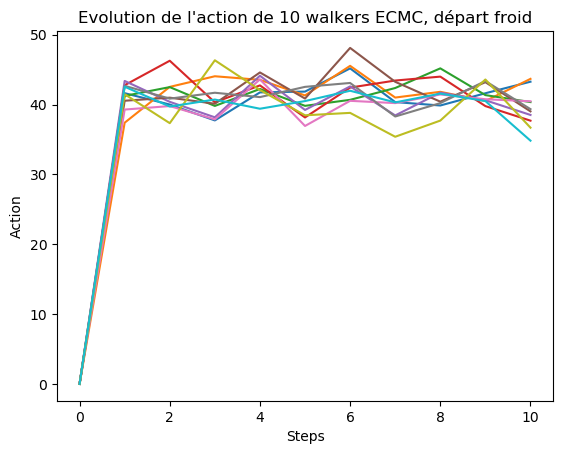

In [97]:
from matplotlib import pyplot as plt

for i in range(len(resultats)):
    plt.plot(resultats[i])
plt.xlabel("Steps")
plt.ylabel("Action")
plt.title("Evolution de l'action de "+ str(len(resultats)) +" walkers ECMC, départ froid")

In [95]:
if __name__ == "__main__":
    L = 4
    T = 4
    beta = 2.55
    cold = False
    angle_l = 1200
    lambda_l = 150
    pos_l = 500
    n=10

    
    nombre_de_processus = 10
    resultats_hot = []

    # Fonction pour collecter les résultats
    def collect_resultat(resultat):
        resultats_hot.append(resultat)

    # Créer un pool de processus
    with multiprocessing.Pool(processes=nombre_de_processus) as pool:
        # Appliquer la fonction de manière asynchrone
        for i in range(nombre_de_processus):
            pool.apply_async(walker_action, args=(L,T,beta,cold,angle_l, lambda_l, pos_l, n), callback=collect_resultat)

        # Attendre la fin de tous les processus
        pool.close()
        pool.join()

    # Afficher les résultats
    print("Résultats :", resultats_hot)

Génération du sample 1...Génération du sample 1...

Variables initialisées, lancement de la boucle...Variables initialisées, lancement de la boucle...

Génération du sample 1...
Variables initialisées, lancement de la boucle...
Génération du sample 1...Génération du sample 1...Génération du sample 1...Génération du sample 1...Génération du sample 1...


Génération du sample 1...Génération du sample 1...

Variables initialisées, lancement de la boucle...Variables initialisées, lancement de la boucle...Variables initialisées, lancement de la boucle...

Variables initialisées, lancement de la boucle...Variables initialisées, lancement de la boucle...


Variables initialisées, lancement de la boucle...

Variables initialisées, lancement de la boucle...



/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))


0% de l parcourus
0% de l parcourus


/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))


0% de l parcourus

/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))


/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))


0% de l parcourus


/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))


0% de l parcourus0% de l parcourus

0% de l parcourus
0% de l parcourus0% de l parcourus

0% de l parcourus


/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma)))
/tmp/ipykernel_5862/4291762139.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(f_lambda_8_solve, x_ini, args=(a,b,c,d,reduce_8(a,b,c,d,gamma))

10% de l parcourus
10% de l parcourus
Changement de direction de déplacement
20% de l parcourus
Changement de direction de déplacement
30% de l parcourus
Changement de direction de déplacement
20% de l parcourus
Changement de direction de déplacement
Changement de direction de déplacement
40% de l parcourus
30% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
Changement de direction de déplacement
40% de l parcourus50% de l parcourus

Changement de lien aléatoire
Changement de direction de déplacement
60% de l parcourus50% de l parcourus

10% de l parcourus
Changement de direction de déplacement
70% de l parcourus60% de l parcourus

Changement de direction de déplacementChangement de direction de déplacement

80% de l parcourus
70% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacement
Changement de direction de déplacement
80% de l parcourus
90% de l parcourus
Changement de lien aléatoire
Changement de direction de déplacem

Text(0.5, 1.0, "Evolution de l'action de 10 walkers ECMC, départ chaud")

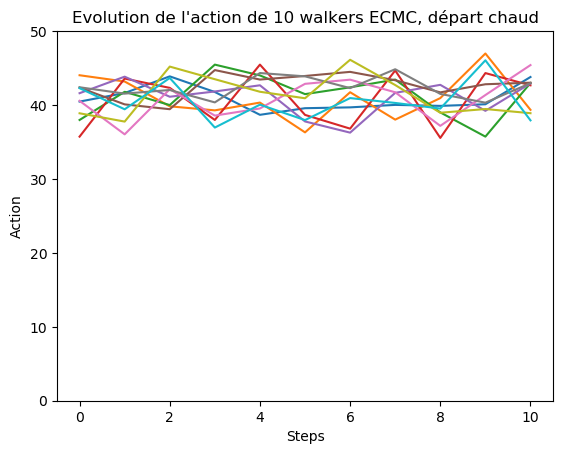

In [104]:
from matplotlib import pyplot as plt

for i in range(len(resultats)):
    plt.plot(resultats_hot[i])
plt.xlabel("Steps")
plt.ylim(0, 50)
plt.ylabel("Action")
plt.title("Evolution de l'action de "+ str(len(resultats)) +" walkers ECMC, départ chaud")

Text(0.5, 1.0, "Comparaison de l'évolution de l'action de 10 walkers ECMC, départ chaud/froid")

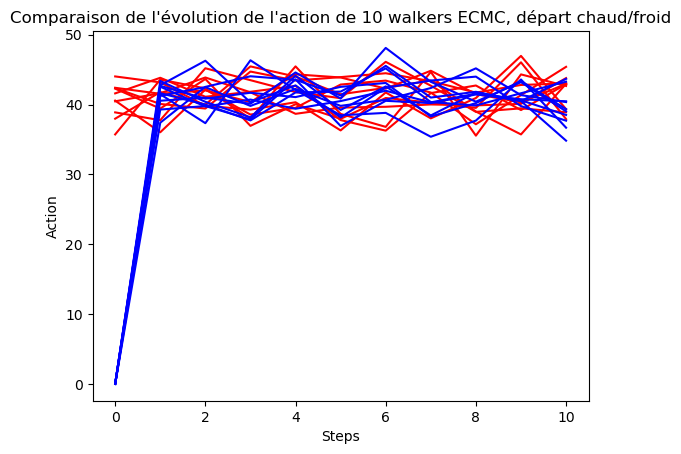

In [102]:
for i in range(len(resultats_hot)):
    plt.plot(resultats_hot[i], color = "red")
for i in range(len(resultats)):
    plt.plot(resultats[i], color = "blue")
plt.xlabel("Steps")
plt.ylabel("Action")
plt.title("Comparaison de l'évolution de l'action de "+ str(len(resultats)) +" walkers ECMC, départ chaud/froid")